In [66]:
import sys

# Setup the environment if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    ! pip install -r /content/drive/MyDrive/Tübingen/Sem1/DLit/Project/requirements.txt


In [67]:
import os
import re
import json
import requests
import PyPDF2
import urllib.request
import tueplots
from tueplots import bundles
from tueplots.constants.color import rgb
from bs4 import BeautifulSoup
from scipy import stats
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from bayes_opt import BayesianOptimization

if IN_COLAB:
    os.chdir('/content/drive/MyDrive/Tübingen/Sem1/DLit/Project/exp')

sys.path.append('../src/')
import maps
from maps import CONCERNS_MAP, ACTIVITIES_MAP, AGE, SEX

### Read the November 2021 Computer and Internet Use data
To download the data, please run `bash download.sh` in the root directory of this project.

In [68]:
# Set the data directory.
DATA_DIR = '../dat/'
year = '2021'
CSV_FILE_PATH = os.path.join(DATA_DIR, f"{year}/nov{year[2:]}pub.csv")

# Read the data.
df21 = pd.read_csv(CSV_FILE_PATH)
df21 = df21[(df21[AGE] >= 10) * (df21[SEX] != -1)]
columns = df21.columns.to_list()
df21


,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,FILLER,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,...,PXEDTRAI,PXEGOVTS,PXUSESVC,PXESRVCS,PXECOMME,PXEGOODS,PXFINANC,PXVOICEA,PXHOMIOT,PWPRMWGT
0,610905110108708,11,2021,1,201,NaN,1,1,1,-1,...,0,0,0,0,0,0,0,0,0,99445490
1,610905110108708,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
5,721914005500521,11,2021,1,201,NaN,2,1,1,-1,...,0,0,0,0,0,0,0,0,0,38703072
6,201967201670009,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
7,201967201670009,11,2021,1,201,NaN,1,1,1,-1,...,1,1,1,1,1,1,1,1,1,40232619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127369,156485901801505,11,2021,1,201,NaN,1,1,1,-1,...,1,1,1,1,1,1,1,1,1,3958005
127370,156485901801505,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
127372,167066394505701,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
127373,167066394505701,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0


### Try Classification

In the previous notebook, we performed some initial exploratory analysis on the dataset. We also looked at some of the primary socio-demographic variables that determine whether a person has concerns or hesitations while using the internet. As we also saw in the initial exploration, the dataset is very large, with ~560 columns. 

In order to efficiently explore the other attributes that might affect a person's perception of risks associated with internet use, we now fit an `XGBoost` classifier to predict whether a person would have concerns with internet used, based on other attributes.

We first begin by adding two columns that indicate whether an individual has some hesitation/concern with any aspect of using the internet.

In [69]:
def has_any_concern(row):
    """
    Returns true if the person has answered yes to any of the concerns.
    """
    for column in [f'{item} == 1' for item in [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8]]]:
            if (row['HEPSCON1'] == 1) or (row['HEPSCON2'] == 1) or (row['HEPSCON3'] == 1)\
                    or (row['HEPSCON4'] == 1) or (row['HEPSCON5'] == 1) or (row['HEPSCON6'] == 1)\
                    or (row['HEPSCON8'] == 1):
                return 1
            else:
                return 0

def hesitates_to_do_activity(row):
    """
    Returns true if the person has answered that they hesitate to do any activity.
    """
    for column in [f'{item} == 1' for item in [f'HEPSPRE{i}' for i in [1,2,3,4,5]]]:
            if (row['HEPSPRE1'] == 1) or (row['HEPSPRE2'] == 1) or (row['HEPSPRE3'] == 1)\
                    or (row['HEPSPRE4'] == 1) or (row['HEPSPRE5'] == 1):
                return 1
            else:
                return 0

# Add the new columns to the dataframe.
df21['HAS_SOME_CONCERN'] = df21.apply(has_any_concern, axis=1)
df21['HESITATES'] = df21.apply(hesitates_to_do_activity, axis=1)

### Additional columns

We add a few more derived attributes based on our EDA. Please note that we add only a subset of the defined columns to the data, since some of them are redundant.

In [70]:
# New variables to add based on our custom maps defined in src/maps.py.

# The state a person belongs to - derived from the state code.
state = lambda x: pd.Categorical(x['GESTFIPS'].map(maps.StatesMap))
# The region a person belongs to - derived from the state code.
region = lambda x: pd.Categorical(x['STATE'].map(maps.RegionsMap))
# Level of education - detailed
educdt = lambda x: pd.Categorical(x['PEEDUCA'].map(maps.EducDTMap))
# Level of education - broad
educ = lambda x: pd.Categorical(x['PEEDUCA'].map(maps.educ))
# Currently enrolled in school
schenr = lambda x: pd.Categorical(
    np.where(x['PESCHENR'] == 1, 1,
    np.where(x['PESCHENR'] == 2, 0, None)))
# marital status
married = lambda x: pd.Categorical(
    np.where(x['PRMARSTA'].isin([1, 2, 3]), 1, 0))

# Race - detailed
wbao = lambda x: pd.Categorical(x['PRDTRACE'].map(maps.race))

# Veteran status
veteran = lambda x: pd.Categorical(
    np.where(x['PEAFEVER'] == 1, 1,
    np.where(x['PEAFEVER'] == 2, 0, None)))

# Citizenship status
forborn = lambda x: pd.Categorical(
    np.where(x['PRCITSHP'].isin([4, 5]), 1,
    np.where(x['PRCITSHP'].isin([1, 2, 3]), 0, None)))

# Citizenship status
citizen = lambda x: pd.Categorical(
    np.where(x['PRCITSHP'].isin([1, 2, 3, 4]), 1,
    np.where(x['PRCITSHP'].isin([5]), 0, None)))

# Industry of employment - detailed
indgrp =  lambda x: pd.Categorical(x['PRMJIND1'].map(maps.ind))

# Management occupation
manager = lambda x: np.where(x.PRDTOCC1 == 1, 1,
                    np.where(x.PRDTOCC1 > 0, 0, None))

# Multiple job holder status
mjh = lambda x: pd.Categorical(
    np.where(x['PRSJMJ']==2, 1, np.where(x['PRSJMJ']==1, 0, None)))

# Number of jobs
numjobs = lambda x: np.where(x.PEMJNUM > 1, x.PEMJNUM,
    np.where((x.MJH == 0) & (x.LFS == "Employed"), 1, 0))

# Type of employment
unemptype = lambda x: pd.Categorical(
    np.where(x['PRUNTYPE'].isin([1, 2, 3]), 'Job Loser',
    np.where(x['PRUNTYPE'] == 4, 'Job Leaver',
    np.where(x['PRUNTYPE'] == 5, 'Re-entrant',
    np.where(x['PRUNTYPE'] == 6, 'New Entrant', None)))))

# Reason for unemployment
layoff = lambda x: pd.Categorical(
    np.where(x['PEMLR'] == 3, 'Layoff',
    np.where(x['PEMLR'] == 4, 'Looking', None)))

# Layoff duration
lfs = lambda x: pd.Categorical(
        np.where(x['PEMLR'].isin([1, 2]), 'Employed',
        np.where(x['PEMLR'].isin([3, 4]), 'Unemployed',
        np.where(x['PEMLR'].isin([5, 6, 7]), 'NILF', np.nan))))

# Education
school = lambda x: pd.Categorical(
        np.where(x.PESCHLVL == 1, 'High School',
        np.where((x.PESCHLVL == 2) & (x.PESCHFT == 1), 'Full-time College',
        np.where((x.PESCHLVL == 2) & (x.PESCHFT == 2), 'Part-time College',
        np.where(x.SCHENR == 0, 'Not Enrolled', None)))))

# Work status - full time?
uslft = lambda x: pd.Categorical(
        np.where((x['PEHRFTPT'] == 1) | (x['PEHRUSL1'] >= 35), 1,
        np.where(x['PEHRFTPT'] == 2, 0,
        np.where(x['PEHRFTPT'] == 3, -4, None))))


df21 = (df21.assign(STATE = state(df21),
    EDUCDT = educdt(df21),
    SCHENR = schenr(df21),
    MARRIED = married(df21),
    VETERAN = veteran(df21),
    FORBORN = forborn(df21),
    CITIZEN = citizen(df21),
    UNEMPTYPE = unemptype(df21),
    LAYOFF = layoff(df21),
    USLFT = uslft(df21),
    )
)

df21 = df21.assign(REGION = region(df21), SCHOOL = school(df21))

### Prepare the data for training

We create a copy of the dataframe, and remove some of the obvious / highly correlated attributes.

In [71]:
# loop through all columns in df21, and add all non numerical and non categorical columns to a list
non_numerical_cols = []
for col in df21.columns:
    if df21[col].dtype == object:
        non_numerical_cols.append(col)

# add columns that contain all NaN values to the list
for col in df21.columns:
    if df21[col].isnull().all():
        non_numerical_cols.append(col)

# Some other columns that are highly correlated with the target variable, and hence should be dropped to help
# us discover other features that more interestingly correlate with the target variable.
non_numerical_cols += ["HAS_SOME_CONCERN", "HESITATES"] + ["HEPSCON" + str(i) for i in range(1, 9)] + ["HEPSPRE" + str(i) for i in range(1, 6)]

# drop all non numerical and non categorical columns from df21
df_train = df21.drop(columns = non_numerical_cols, errors="ignore")

In [72]:
# reference: https://www.kaggle.com/code/tilii7/bayesian-optimization-of-xgboost-parameters
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    """
    Hyperparm seach for binary classification
    """
    params = {'eval_metric': 'error',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'tree_method': 'gpu_hist',
              'predictor': 'gpu_predictor',
              'verbosity': 0}
    # Use around 1000 boosting rounds in the full model
    # Perform 3-fold Cross-validation (CV), and calculate the CV error for each fold.
    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=3)

    return -cv_result['test-error-mean'].iloc[-1]

In [ ]:
# os.mkdir(f'../res/{year}')

# Use the below as the target variables in order to find the most important features for each of them.
columns_to_process = [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8]] + [f'HEPSPRE{i}' for i in [1,2,3,4,5]] + ["HAS_SOME_CONCERN", "HESITATES"]

for column in columns_to_process:

  # Filter out all rows where the target variable is -1
  df21_filtered = df21[df21[column] != -1][column]

  # The other columns use 2 for yes and 1 for no, so we need to convert them to 1 and 0 respectively.
  if column not in ["HAS_SOME_CONCERN", "HESITATES"]:
    df21_filtered = df21_filtered.apply(lambda x : x-1)

  # Create new variable for filtered df_train1
  df_train1_filtered = df_train.loc[df21_filtered.index]

  # Create DMatrix for XGBoost classifier
  xgtrain = xgb.DMatrix(df_train1_filtered, label=df21_filtered, enable_categorical=True)

  # Perform hyperparameter search
  xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (7, 12),
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.5, 0.9)})
  xgb_bo.maximize(init_points=5, n_iter=10)

  # Get the best parameters
  sorted_res = sorted(xgb_bo.res,key = lambda x: x['target'])
  params = sorted_res[-1]
  params['params']['max_depth'] = int(params['params']['max_depth'])

  # Train the model with the best parameters on the entire dataset
  model = xgb.train(params, xgtrain, num_boost_round=1000)

  # Reference: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
  # Save the feature importance to a file
  feature_important = model.get_score(importance_type='gain')
  keys = list(feature_important.keys())
  values = list(feature_important.values())

  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
  fig = data.nlargest(30, columns="score").plot(kind='barh', figsize = (20,10)).get_figure() 

  fig.savefig(f'../res/{year}/{column}.jpg')
  data.to_csv(f'../res/{year}/{column}.csv')


### Feature Importance

As we can see, the model is able to fit the data well - we get a 3-fold cross validation error of around 8-14%, so the classifier is able to predict the target variables well. We now plot the top 20 features for each of the target variables. We categorize the columns into categories such as work, financial, digital access, safety, etc.

In [27]:
from maps import feat_dict, feat_dict_yearwise, category_category_new_mapping


### Final Importance plots

Below, we plot the categorized variables that are important to determin each target variable.

In [50]:
category_color_map = {
'Digital access' : rgb.tue_lightblue,
'Online activities': rgb.tue_lightgold,
"Wealth related": rgb.tue_lightgreen,
"Safety": rgb.tue_lightorange,
"Personal Characteristics": rgb.tue_violet,
}

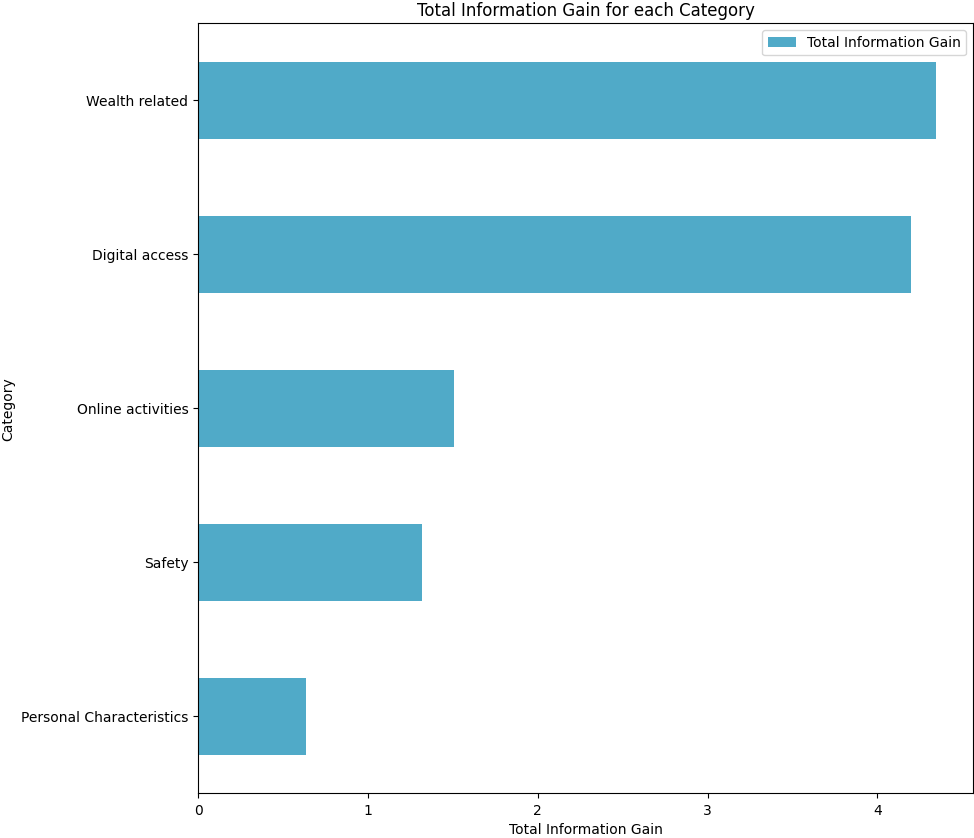

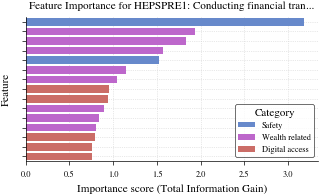

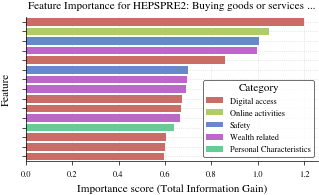

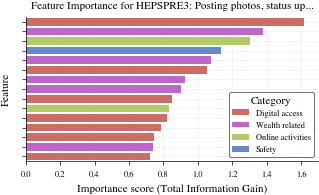

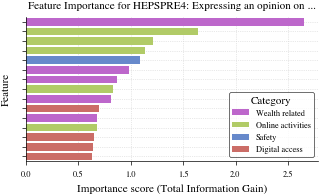

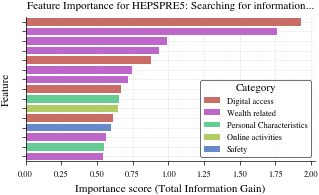

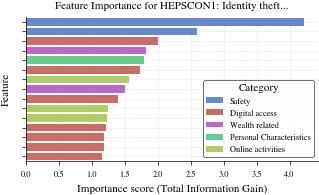

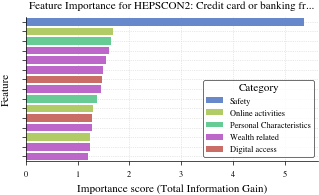

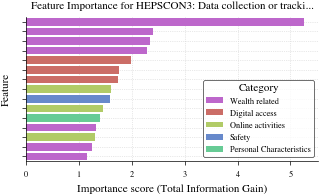

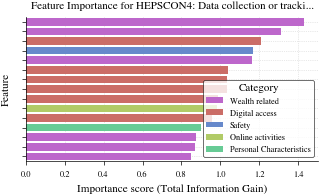

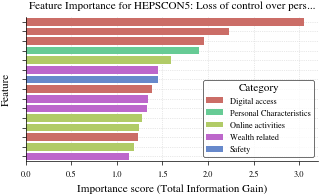

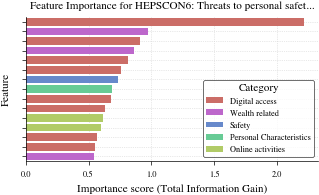

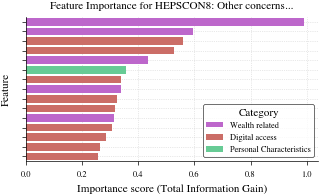

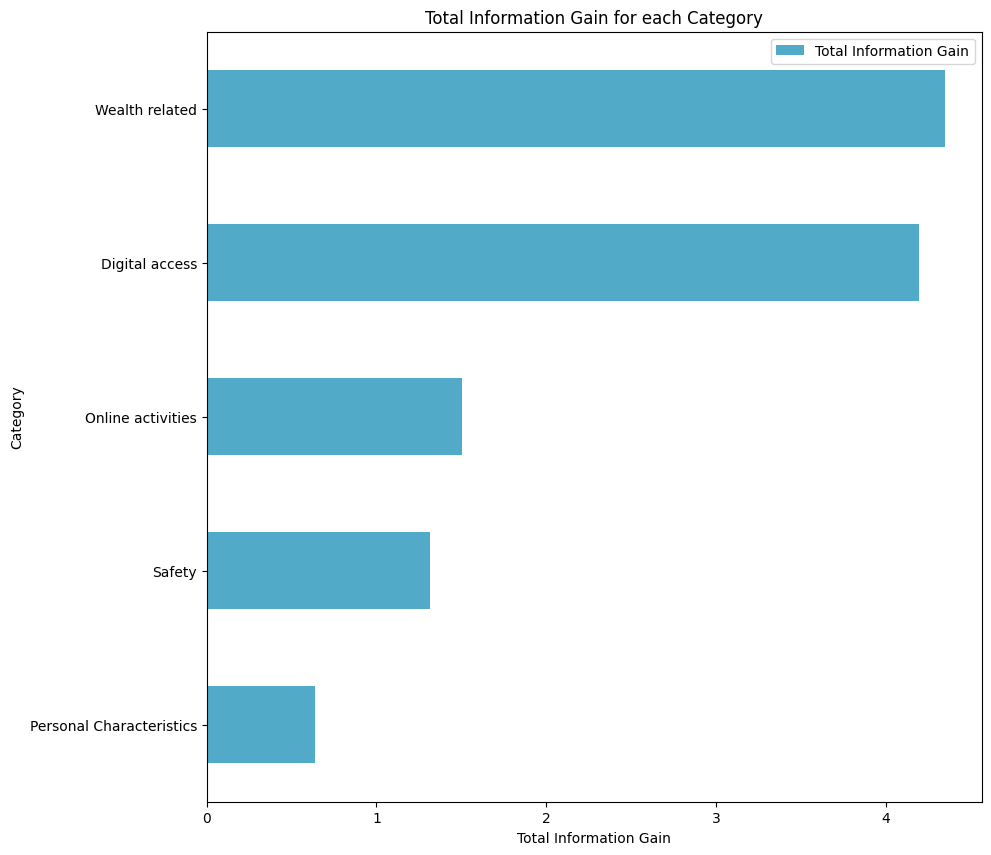

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

path = os.path.join(os.getcwd(), '../res', year + '_importance_plots')

# Create a color palette
# Create a list of unique categories
all_categories = []
for var_name in feat_dict.keys():
    all_categories += list(feat_dict[var_name].values())
unique_categories = list(set(all_categories))

unique_categories.sort()

# Create a color palette
palette = sns.color_palette("hls", len(unique_categories))

# Create a dictionary mapping each category to a color
color_dict = dict(zip(unique_categories, palette))

# color_dict = category_color_map

importance_dict = {key: 0 for key in category_color_map.keys()}

with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):
        
    for var_name in [f'HEPSPRE{i}' for i in [1,2,3,4,5]] + [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8,]]:

        fig, ax = plt.subplots()
        
        importance_df = pd.read_csv(os.path.join(path, f'{var_name}.csv'))
        # select top 20 rows of the dataframe
        importance_df = importance_df.iloc[:15]

        # Calculate the total information gain for each category, and normalize it by dividing by the sum of all
        # information gains
        information_gain_dict = defaultdict(int)
        for index, row in importance_df.iterrows():
            category = feat_dict[var_name][row['Unnamed: 0']]
            information_gain_dict[category] += row['score']
        total_information_gain = sum(information_gain_dict.values())
        for category in information_gain_dict.keys():
            information_gain_dict[category] /= total_information_gain

        # add the normalized information gain to the dictionary
        for category in information_gain_dict.keys():
            importance_dict[category] += information_gain_dict[category]

        # plot a bar chart of the feature importance, use the variable names as the y-axis labels, and use 
        # different colors for the bars depending on the category of the variable
        
        var_categories = feat_dict[var_name]

        #rename the first column to 'features'
        importance_df.rename(columns={'Unnamed: 0': 'features'}, inplace=True)

        # Create a new column in importance_df for the categories using var_categories
        importance_df['category'] = importance_df['features'].map(var_categories)

        # Plot the bar chart
        plot = sns.barplot(x='score', y='features', hue='category', data=importance_df, palette=color_dict, dodge=False)

        # Remove y labels
        plot.set_yticklabels([])

        # Show the legend
        plt.legend(title='Category')

        feature_description_map = ACTIVITIES_MAP if var_name.startswith("HEPSPRE") else CONCERNS_MAP

        plt.xlabel('Importance score (Total Information Gain)')
        plt.ylabel('Feature')

        # Add spines
        ax.spines["top"].set(visible = False)
        ax.spines["right"].set(visible = False)
        ax.grid(True, color = "lightgrey", ls = ":")

        plt.title(f'Feature Importance for {var_name}: {feature_description_map[var_name][:25]}...')

        plt.savefig(path + f'/{var_name}_colored.pdf', dpi=300, bbox_inches='tight')

        # Show the plot
        plt.show()

# Plot a bar chart of the total information gain for each category
df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['Total Information Gain'])
df.sort_values(by=['Total Information Gain'], inplace=True)
df.plot(kind='barh', figsize=(10, 10), color=category_color_map.values())
plt.xlabel('Total Information Gain')
plt.ylabel('Category')
plt.title('Total Information Gain for each Category')
plt.show()


### Factors affecting hesitations on affecting over the years

We next plot the imporance scores from 2015 to 2021 to look for changes in the factors.

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

for year in map(str, range(2015, 2022, 2)):

    path = os.path.join(os.getcwd(), '../res', year + '_importance_plots')

    # Create a color palette
    # Create a list of unique categories
    all_categories = []
    for var_name in feat_dict.keys():
        all_categories += list(feat_dict[var_name].values())
    unique_categories = list(set(all_categories))

    unique_categories.sort()

    # Create a color palette
    palette = sns.color_palette("hls", len(unique_categories))

    # Create a dictionary mapping each category to a color
    color_dict = dict(zip(unique_categories, palette))

    # Comment this out to use seaborn colors
    color_dict = category_category_new_mapping
    


    with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):
            
        for var_name in ["HEPSPRE4"]:

            fig, ax = plt.subplots()
            
            importance_df = pd.read_csv(os.path.join(path, f'{var_name}.csv'))
            # select top 20 rows of the dataframe
            importance_df = importance_df.iloc[:15]

            # plot a bar chart of the feature importance, use the variable names as the y-axis labels, and use 
            # different colors for the bars depending on the category of the variable
            
            var_categories = feat_dict_yearwise[year]

            #rename the first column to 'features'
            importance_df.rename(columns={'Unnamed: 0': 'features'}, inplace=True)

            # Create a new column in importance_df for the categories using var_categories
            importance_df['category'] = importance_df['features'].map(var_categories)

            # Plot the bar chart
            plot = sns.barplot(x='score', y='features', hue='category', data=importance_df, palette=color_dict, dodge=False)

            # Remove y labels
            plot.set_yticklabels([])

            # Show the legend
            plt.legend(title='Category')

            feature_description_map = ACTIVITIES_MAP if var_name.startswith("HEPSPRE") else CONCERNS_MAP

            plt.xlabel('Importance score (Total Information Gain)')
            plt.ylabel('Feature')

            # Add spines
            ax.spines["top"].set(visible = False)
            ax.spines["right"].set(visible = False)
            ax.grid(True, color = "lightgrey", ls = ":")

            plt.title(f'Feature Importance for {var_name}: {feature_description_map[var_name][:25]}...')

            plt.savefig(path + f'/{var_name}_colored.pdf', dpi=300, bbox_inches='tight')

            # Show the plot
            plt.show()

ValueError: Invalid RGBA argument: 0.14360159991976792

### Distribution of factors over time

We now use plots to visualize the shift in the distribution of factors over the years

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

year_to_importance_distribution_map = {}

for year in map(str, range(2015, 2022, 2)):
    path = os.path.join(os.getcwd(), '../res', year + '_importance_plots')
    importance_df = pd.read_csv(os.path.join(path, f'HEPSPRE4.csv'))
    importance_map = {}
    for key in category_category_new_mapping.keys():
        importance_map[key] = 1e-7

    # select top 20 rows of the dataframe
    importance_df = importance_df.iloc[:20]

    for index, row in importance_df.iterrows():
        feature_name = row['Unnamed: 0']
        print(feature_name)
        print(feat_dict_yearwise[year])
        importance_map[feat_dict_yearwise[year][feature_name]] += row['score']

    # normalize the importance scores
    total = sum(importance_map.values())
    for key in importance_map.keys():
        importance_map[key] /= total

    year_to_importance_distribution_map[year] = importance_map

HENOHM5
{'HENOHM5': 'Digital access', 'HECBULLY': 'Safety', 'HECYBA': 'Safety', 'HEINCAFE': 'Digital access', 'PEIO2ICD': 'Wealth related', 'HEINTRAV': 'Digital access', 'PXINUSYR': 'Personal Characteristics', 'PXMLR': 'Wealth related', 'HEDESKTP': 'Digital access', 'HHWGT83': 'Wealth related', 'HEINSCHL': 'Digital access', 'HHWGT21': 'Wealth related', 'GTCSA': 'Personal Characteristics', 'HHWGT121': 'Wealth related', 'HHWGT107': 'Wealth related', 'HHWGT94': 'Wealth related', 'HEHOMSU3': 'Digital access', 'HEINOTHR': 'Digital access', 'PXJHWKO': 'Wealth related', 'PXDISEYE': 'Personal Characteristics', 'HHWGT122': 'Wealth related', 'HEHOMTE4': 'Digital access', 'HHWGT92': 'Wealth related', 'HEHOMSU4': 'Digital access'}
HECBULLY
{'HENOHM5': 'Digital access', 'HECBULLY': 'Safety', 'HECYBA': 'Safety', 'HEINCAFE': 'Digital access', 'PEIO2ICD': 'Wealth related', 'HEINTRAV': 'Digital access', 'PXINUSYR': 'Personal Characteristics', 'PXMLR': 'Wealth related', 'HEDESKTP': 'Digital access', 'HH

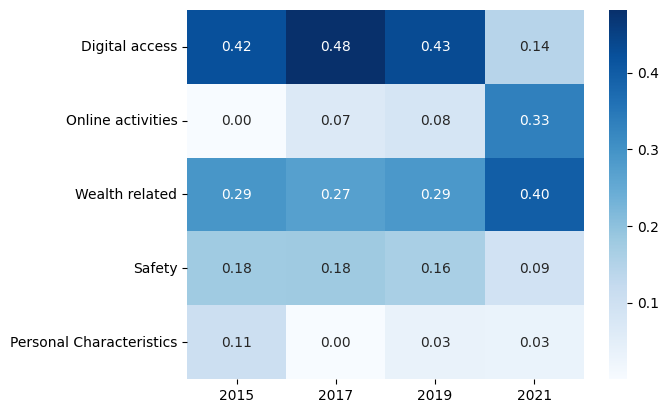

In [36]:
# Create a heatmap of the importance distribution - year vs category
importance_distribution_df = pd.DataFrame.from_dict(year_to_importance_distribution_map)
importance_distribution_df = importance_distribution_df.fillna(0)

importance_distribution_df.head()
# draw the heatmap, show the values of the cells
sns.heatmap(importance_distribution_df, annot=True, cmap='Blues', fmt='.2f')
plt.show()

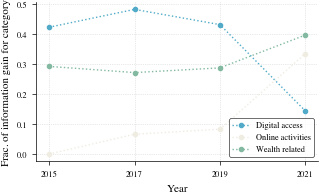

In [77]:
years = [int(year) for year in importance_distribution_df.columns.to_list()]

# draw a line plot of the importance distribution - year vs category
with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):

    fig, ax = plt.subplots()

    for category in ['Digital access', 'Online activities', 'Wealth related']:
        values = []

        for year in years:
            values.append(year_to_importance_distribution_map[str(year)][category])

        ax.plot(
            years, 
            values, 
            label=category, 
            color=category_color_map[category],
            ls=':',
            marker="."
            )


    ax.set_xlabel("Year")
    ax.set_ylabel("Frac. of information gain for category")
    # ax.set_title("Percentage of people with hesitation over time")

    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
    ax.grid(True, color = "lightgrey", ls = ":")

    # Set ticks
    ax.set_xticks(years)

    plt.legend()
    plt.savefig("../res/figures/categories_over_time.pdf")
    plt.show()
    plt.close(fig)

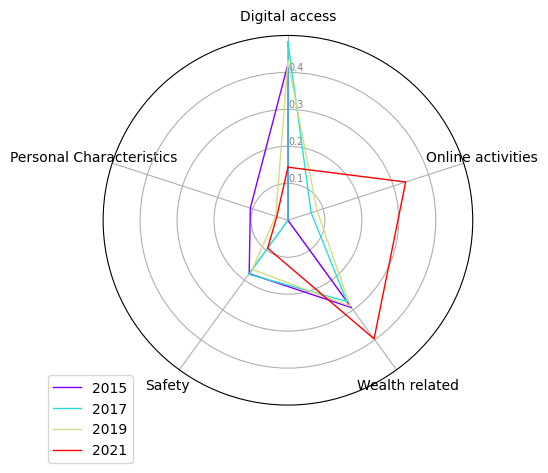

In [38]:
# draw a radar plot of the importance distribution - year vs category.
pi = np.pi
import matplotlib.cm as cm

# Convert the dictionary to a DataFrame
df = pd.DataFrame(year_to_importance_distribution_map).T

# ------- PART 1: Create background

# number of variable
categories=list(df)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.3,0.4], map(str, [0.1,0.2,0.3,0.4]), color="grey", size=7)
plt.ylim(0,0.5)

# ------- PART 2: Add plots

# Create a color map
colors = cm.rainbow(np.linspace(0, 1, len(df)))

# Plot each year's category distribution
for color, (year, row) in zip(colors, df.iterrows()):
    values=row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=year, color=color)
    # ax.fill(angles, values, color=color, alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

In [26]:
for year in year_to_importance_distribution_map:
    print(year_to_importance_distribution_map[year])

defaultdict(<function <lambda> at 0x2861ca160>, {'Digital access': 0.42257638115154067, 'Safety': 0.17838854612589772, 'Wealth related': 0.2920739142135364, 'Personal Characteristics': 0.10696115850902524})
defaultdict(<function <lambda> at 0x284fe6f70>, {'Safety': 0.18060687622216207, 'Digital access': 0.481967435653147, 'Online activities': 0.06601343316067487, 'Wealth related': 0.2714122549640161})
defaultdict(<function <lambda> at 0x284d184c0>, {'Wealth related': 0.2871281950925655, 'Digital access': 0.4311816837409457, 'Safety': 0.1642998331857316, 'Online activities': 0.08285011735996083, 'Personal Characteristics': 0.03454017062079651})
defaultdict(<function <lambda> at 0x284d18af0>, {'Wealth related': 0.3964925655309445, 'Online activities': 0.33489925584293956, 'Safety': 0.09330508283890833, 'Digital access': 0.14360175340677916, 'Personal Characteristics': 0.0317013423804286})
